In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-cost-prediction/medical_insurance.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)   # prevent line wrapping
df = pd.read_csv("/kaggle/input/medical-insurance-cost-prediction/medical_insurance.csv")
df

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,diastolic_bp,ldl,hba1c,plan_type,network_tier,deductible,copay,policy_term_years,policy_changes_last_2yrs,provider_quality,risk_score,annual_medical_cost,annual_premium,monthly_premium,claims_count,avg_claim_amount,total_claims_paid,chronic_count,hypertension,diabetes,asthma,copd,cardiovascular_disease,cancer_history,kidney_disease,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,27.4,Never,NaN,2,0,0,4,121.0,76.0,123.8,5.28,PPO,Bronze,1000,20,4,0,3.73,0.5714,6938.06,876.05,73.00,1,4672.59,4672.59,1,0,0,0,0,0,0,0,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,1,26.6,Never,Weekly,2,0,0,3,131.0,79.0,97.3,4.82,POS,Gold,1000,10,1,0,3.10,1.0000,1632.61,445.10,37.09,4,297.27,1189.08,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,3,31.5,Never,NaN,1,0,0,4,160.0,84.0,129.5,5.51,HMO,Platinum,500,20,10,0,3.90,1.0000,7661.01,1538.02,128.17,0,0.00,0.00,3,1,0,0,0,0,1,0,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,3,31.6,Never,NaN,0,0,0,1,104.0,68.0,160.3,8.50,HMO,Silver,500,20,5,0,3.89,0.2857,5130.27,820.63,68.39,0,0.00,0.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,30.5,Never,Daily,3,0,0,2,136.0,83.0,171.0,5.20,POS,Platinum,500,10,7,0,3.90,0.8681,1700.73,500.93,41.74,1,1002.24,1002.24,2,1,0,0,0,0,0,0,0,1,0,2,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6266,50,Male,West,Urban,127200.0,No HS,Married,Employed,2,0,28.2,Never,Occasional,0,0,0,1,115.0,74.0,102.5,4.98,PPO,Bronze,500,10,10,0,3.93,0.3516,1295.04,329.32,27.44,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
99996,54887,42,Male,East,Suburban,21600.0,HS,Married,Employed,2,0,27.6,Never,Occasional,0,0,0,1,101.0,66.0,177.1,5.66,PPO,Silver,5000,20,4,0,3.94,0.2637,1451.73,424.21,35.35,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99997,76821,41,Male,West,Rural,81900.0,HS,Divorced,Unemployed,1,0,29.8,Former,Weekly,7,0,0,1,128.0,83.0,118.8,5.52,PPO,Gold,500,30,9,0,4.14,0.4505,2291.00,534.90,44.58,8,312.56,2500.48,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
99998,861,51,Female,South,Urban,43400.0,Doctorate,Single,Unemployed,3,2,21.9,Never,Occasional,4,0,0,2,110.0,73.0,134.9,5.25,POS,Bronze,2000,20,3,0,2.76,0.5604,1279.76,342.86,28.57,2,552.38,1104.76,1,0,0,0,0,0,0,0,0,0,1,0,0,2,2,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

In [5]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)
for col in categorical_cols:
    print(df[col].value_counts())

['sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq', 'plan_type', 'network_tier']
sex
Female    49193
Male      48794
Other      2013
Name: count, dtype: int64
region
South      28029
North      22027
East       19984
West       17879
Central    12081
Name: count, dtype: int64
urban_rural
Urban       60019
Suburban    25021
Rural       14960
Name: count, dtype: int64
education
Bachelors       27996
Some College    25112
HS              24827
Masters         13987
No HS            5120
Doctorate        2958
Name: count, dtype: int64
marital_status
Married     53252
Single      35715
Divorced     6984
Widowed      4049
Name: count, dtype: int64
employment_status
Employed         55269
Retired          19864
Unemployed       12939
Self-employed    11928
Name: count, dtype: int64
smoker
Never      69709
Former     18163
Current    12128
Name: count, dtype: int64
alcohol_freq
Occasional    45078
Weekly        19833
Daily          500

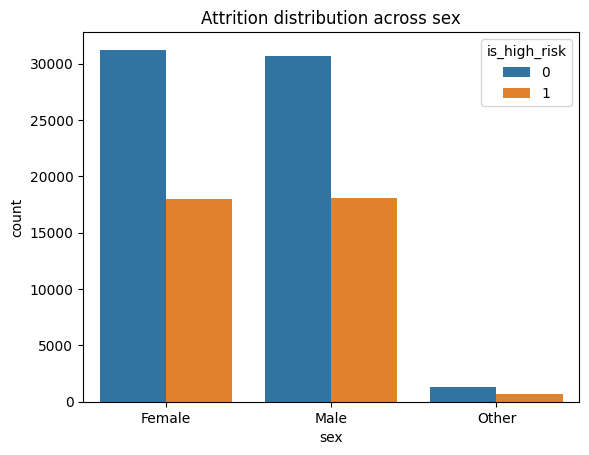

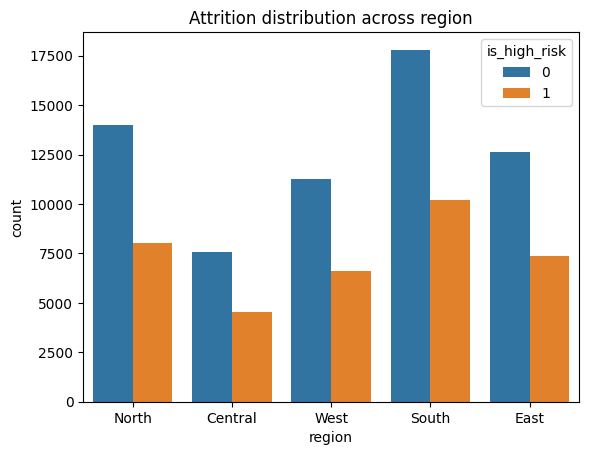

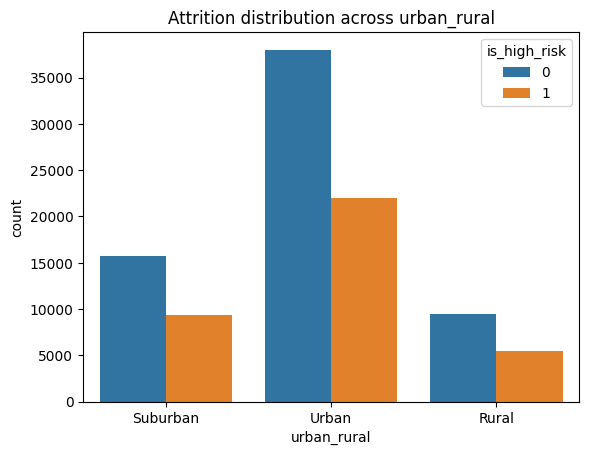

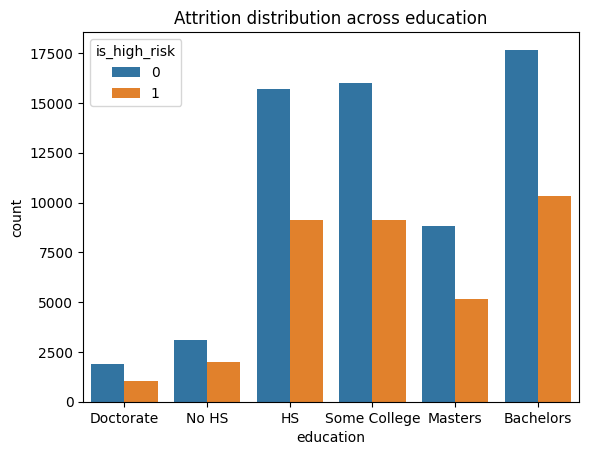

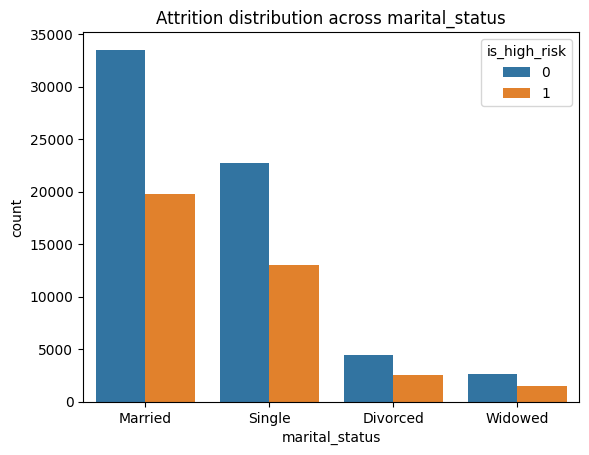

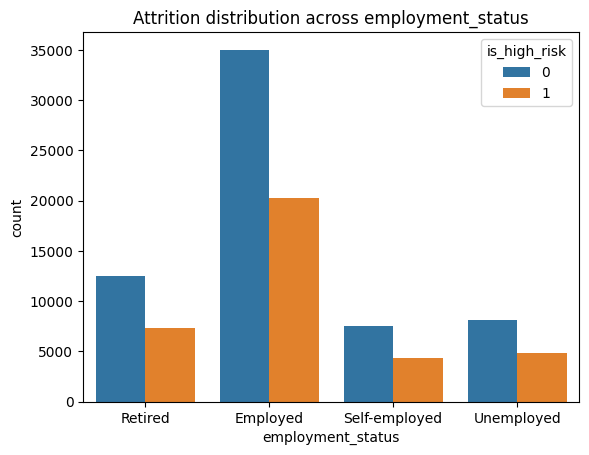

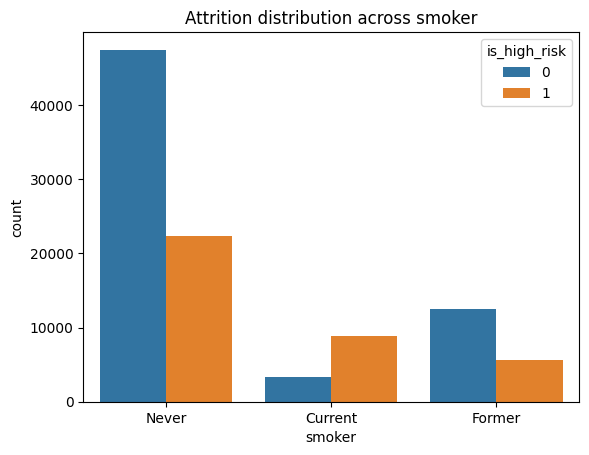

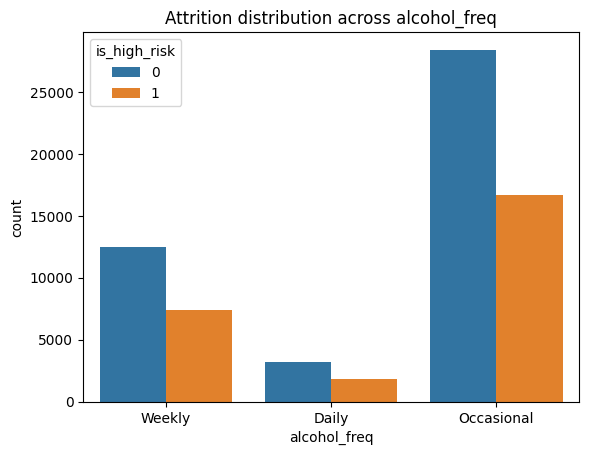

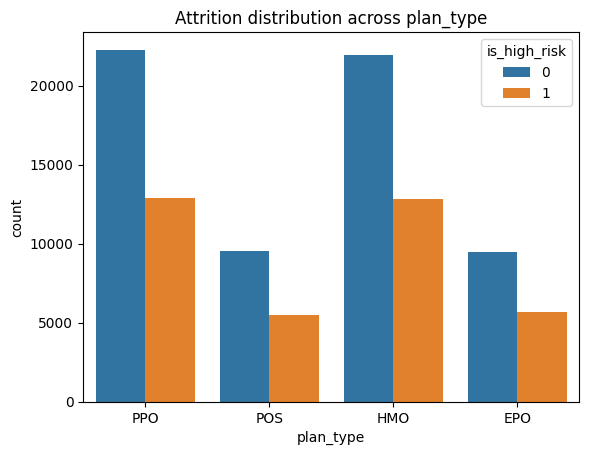

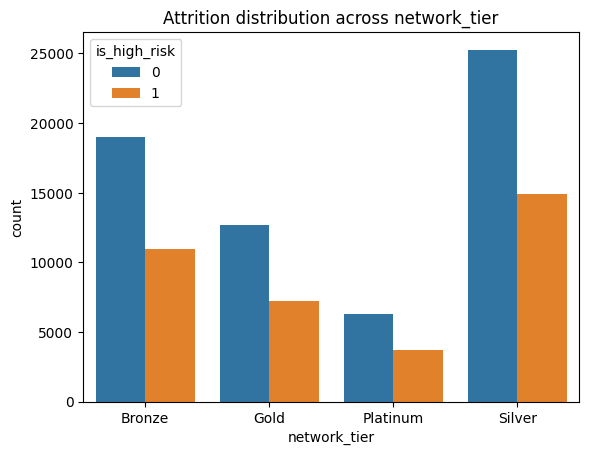

In [6]:
for category in categorical_cols:
  sns.countplot(x=category, hue='is_high_risk', data=df)
  plt.title(f'Attrition distribution across {category}')
  plt.show()

In [7]:
df['alcohol_freq'] = df['alcohol_freq'].fillna(df['alcohol_freq'].mode()[0])

In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

nominal_cols = ['sex', 'region', 'marital_status', 'employment_status', 'plan_type']
ordinal_cols = ['urban_rural', 'education', 'smoker', 'alcohol_freq', 'network_tier']

# Define custom order
education_order = [['No HS', 'HS', 'Some College', 'Bachelors', 'Masters', 'Doctorate']]
smoker_order = [['Never', 'Former', 'Current']]
alcohol_order = [['Occasional', 'Weekly', 'Daily']]
urban_order = [['Rural', 'Suburban', 'Urban']]
network_order = [['Silver', 'Bronze', 'Gold', 'Platinum']]

ordinal_encoder = OrdinalEncoder(categories=[urban_order[0], education_order[0], smoker_order[0], alcohol_order[0],  network_order[0]])
onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_encoder, ordinal_cols),
        ('nom', onehot_encoder, nominal_cols)
    ],
    remainder='passthrough'
)

# Fit and transform
df_encoded = preprocessor.fit_transform(df)

# Get all feature names
encoded_feature_names = (
    preprocessor.named_transformers_['ord'].get_feature_names_out(ordinal_cols).tolist()
    + preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols).tolist()
)

# Get names of numeric passthrough columns
passthrough_cols = [col for col in df.columns if col not in nominal_cols + ordinal_cols]

# Combine all feature names
all_feature_names = encoded_feature_names + passthrough_cols

# Convert to DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=all_feature_names)

df_encoded.head()


,urban_rural,education,smoker,alcohol_freq,network_tier,sex_Male,sex_Other,region_East,region_North,region_South,region_West,marital_status_Married,marital_status_Single,marital_status_Widowed,employment_status_Retired,employment_status_Self-employed,employment_status_Unemployed,plan_type_HMO,plan_type_POS,plan_type_PPO,person_id,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,diastolic_bp,ldl,hba1c,deductible,copay,policy_term_years,policy_changes_last_2yrs,provider_quality,risk_score,annual_medical_cost,annual_premium,monthly_premium,claims_count,avg_claim_amount,total_claims_paid,chronic_count,hypertension,diabetes,asthma,copd,cardiovascular_disease,cancer_history,kidney_disease,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,75722.0,52.0,22700.0,3.0,1.0,27.4,2.0,0.0,0.0,4.0,121.0,76.0,123.8,5.28,1000.0,20.0,4.0,0.0,3.73,0.5714,6938.06,876.05,73.00,1.0,4672.59,4672.59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0
1,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80185.0,79.0,12800.0,3.0,1.0,26.6,2.0,0.0,0.0,3.0,131.0,79.0,97.3,4.82,1000.0,10.0,1.0,0.0,3.10,1.0000,1632.61,445.10,37.09,4.0,297.27,1189.08,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,19865.0,68.0,40700.0,5.0,3.0,31.5,1.0,0.0,0.0,4.0,160.0,84.0,129.5,5.51,500.0,20.0,10.0,0.0,3.90,1.0000,7661.01,1538.02,128.17,0.0,0.00,0.00,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0
3,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,76700.0,15.0,15600.0,5.0,3.0,31.6,0.0,0.0,0.0,1.0,104.0,68.0,160.3,8.50,500.0,20.0,5.0,0.0,3.89,0.2857,5130.27,820.63,68.39,0.0,0.00,0.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,5.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,92992.0,53.0,89600.0,2.0,0.0,30.5,3.0,0.0,0.0,2.0,136.0,83.0,171.0,5.20,500.0,10.0,7.0,0.0,3.90,0.8681,1700.73,500.93,41.74,1.0,1002.24,1002.24,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0


In [9]:
y = df_encoded['is_high_risk']
X = df_encoded.drop(columns=['is_high_risk'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from sklearn.preprocessing import StandardScaler

num_cols = ['income', 'bmi', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c', 'deductible', 'copay', 'provider_quality', 'risk_score', 'annual_medical_cost', 'annual_premium', 'monthly_premium', 'avg_claim_amount', 'total_claims_paid']
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train_scaled = scaler.transform(X_train[num_cols])
X_test_scaled  = scaler.transform(X_test[num_cols])

In [12]:
class SimpleNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)   # single logit for binary classification
        )

    def forward(self, x):
        return self.net(x)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values.astype(np.float32).reshape(-1, 1)).to(device)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test.values.astype(np.float32).reshape(-1, 1)).to(device)

batch_size = 64
train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Using device: cpu


In [14]:
# ---------------------
# 5) Define the neural network
# ---------------------
input_dim = X_train_t.shape[1]
model = SimpleNN(input_dim).to(device)

In [15]:
# ---------------------
# 6) Loss, optimizer
# ---------------------
criterion = nn.BCEWithLogitsLoss()  # stable for logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optional: lr scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [16]:
# ---------------------
# 7) Training loop
# ---------------------
n_epochs = 20
model.train()
for epoch in range(1, n_epochs+1):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} - Train loss: {epoch_loss:.4f}")


Epoch 01 - Train loss: 0.0778
Epoch 05 - Train loss: 0.0092
Epoch 10 - Train loss: 0.0033
Epoch 15 - Train loss: 0.0027
Epoch 20 - Train loss: 0.0030


In [17]:
# ---------------------
# 8) Evaluation on test set
# ---------------------
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t).cpu().numpy().reshape(-1)
    probs_test = 1 / (1 + np.exp(-logits_test))   # sigmoid
    preds_test = (probs_test >= 0.5).astype(int)

y_test_np = y_test_t.cpu().numpy().reshape(-1).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test_np, preds_test))
print("Accuracy :", accuracy_score(y_test_np, preds_test))
print("Precision:", precision_score(y_test_np, preds_test, zero_division=0))
print("Recall   :", recall_score(y_test_np, preds_test, zero_division=0))
print("F1 score :", f1_score(y_test_np, preds_test, zero_division=0))
try:
    print("ROC AUC  :", roc_auc_score(y_test_np, probs_test))
except Exception as e:
    print("ROC AUC error:", e)

# Optionally show top-k feature weights (first layer)
with torch.no_grad():
    weights = model.net[0].weight.cpu().numpy()  # shape (128, input_dim)
    # mean absolute weight per input feature as a simple importance proxy
    imp = np.mean(np.abs(weights), axis=0)
    feat_imp = pd.Series(imp, index=num_cols).sort_values(ascending=False).head(10)
    print("\nTop input features by mean abs weight (proxy):\n", feat_imp)


Confusion Matrix:
 [[12644     0]
 [    5  7351]]
Accuracy : 0.99975
Precision: 1.0
Recall   : 0.9993202827623708
F1 score : 0.9996600258380363
ROC AUC  : 0.9999996774514848

Top input features by mean abs weight (proxy):
 risk_score             1.062178
monthly_premium        0.107093
annual_premium         0.095261
annual_medical_cost    0.092473
total_claims_paid      0.071865
avg_claim_amount       0.066807
copay                  0.057272
diastolic_bp           0.054587
deductible             0.054517
systolic_bp            0.052856
dtype: float32
